# Escolha de modelos e análise de erros

Nesta fase vamos fazer o seguinte:

- Construir uma *pipeline* de processamento dos dados;
- Elencar alguns modelos a serem analisados;
- Fazer mais uma separação de dados. Desta vez vamos dividir o conjunto de treino em dois: treino e validação;
- Escolher o melhor modelo baseado no erro no conjunto de validação;
- Analisar o *resíduo*: a diferença entre o valor predito e o valor real. Será que tem algum padrão residual aqui?

Primeiro, vamos carregar os dados pré-processados:

In [3]:
from pathlib import Path

import pandas as pd
from lab01.config import DATA_DIR
from lab01.dataloader import load_preprocessed_data

In [7]:
def load_X_y(data_dir: Path) -> tuple[pd.DataFrame, pd.Series]:
    data = load_preprocessed_data(DATA_DIR)
    X = data.drop(columns=['log_median_house_value'])
    y = data['log_median_house_value']
    return X, y


X, y = load_X_y(DATA_DIR)

Vamos agora dividir os dados em treino e teste, e dividir novamente em treino (final) e validação.

In [8]:
from sklearn.model_selection import train_test_split


def split_data(
    X,
    y,
    test_size=0.25,
    random_seed=42,
) -> tuple[
        pd.DataFrame,
        pd.DataFrame,
        pd.Series,
        pd.Series,
]:
    return train_test_split(
        X,
        y,
        test_size=test_size,
        random_state=random_seed,
    )


X_train, X_test, y_train, y_test = split_data(X, y)
X_train_val, X_test_val, y_train_val, y_test_val = split_data(X_train, y_train)

In [9]:
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (OneHotEncoder, PolynomialFeatures,
                                   StandardScaler)

In [10]:
geo_cols = [
    'longitude',
    'latitude',
]

numerical_cols = [
    'housing_median_age',
    'log_households',
    'log_median_income',
    'log_rooms_per_household',
    'log_population_per_household',
    'log_bedrooms_per_room',
]

categorical_cols = [
    'ocean_proximity',
]

geo_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('cluster', KMeans(n_clusters=50)),
])

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('poly', PolynomialFeatures(degree=3, include_bias=False)),
    ('scaler', StandardScaler()),
])

cat_pipeline = Pipeline([
    ('encoder', OneHotEncoder(sparse_output=False)),
])

preprocessing_pipe = ColumnTransformer(
    transformers=[
        ('geo', geo_pipeline, geo_cols),
        ('num', num_pipeline, numerical_cols),
        ('cat', cat_pipeline, categorical_cols),
    ],
    remainder='passthrough',
)

preprocessing_pipe

ColumnTransformer(remainder='passthrough',
                  transformers=[('geo',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('cluster',
                                                  KMeans(n_clusters=50))]),
                                 ['longitude', 'latitude']),
                                ('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('poly',
                                                  PolynomialFeatures(degree=3,
                                                                     include_bias=False)),
                                                 ('scaler', StandardScaler())]),
                                 ['housing_median_age', 'log_households',
                                  'log_median_income',
                                  'log_rooms_per_household',
                                  'log_population_per_household',
                                  'log_bedrooms_per_room']),
                                ('cat',
                                 Pipeline(steps=[('encoder',
                                                  OneHotEncoder(sparse_output=False))]),
                                 ['ocean_proximity'])])

In [11]:
preprocessing_pipe.fit(X_train_val)

preprocessing_pipe

ColumnTransformer(remainder='passthrough',
                  transformers=[('geo',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('cluster',
                                                  KMeans(n_clusters=50))]),
                                 ['longitude', 'latitude']),
                                ('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('poly',
                                                  PolynomialFeatures(degree=3,
                                                                     include_bias=False)),
                                                 ('scaler', StandardScaler())]),
                                 ['housing_median_age', 'log_households',
                                  'log_median_income',
                                  'log_rooms_per_household',
                                  'log_population_per_household',
                                  'log_bedrooms_per_room']),
                                ('cat',
                                 Pipeline(steps=[('encoder',
                                                  OneHotEncoder(sparse_output=False))]),
                                 ['ocean_proximity'])])

## Escolha de modelos

In [12]:
from sklearn.linear_model import LinearRegression

lin_reg = Pipeline([
    ('preprocessing', preprocessing_pipe),
    ('regression', LinearRegression()),
])

In [13]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = Pipeline([
    ('preprocessing', preprocessing_pipe),
    ('regression', DecisionTreeRegressor(random_state=42)),
])

In [14]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = Pipeline([
    ('preprocessing', preprocessing_pipe),
    (
        'regression',
        RandomForestRegressor(
            random_state=42,
            n_jobs=-1,
        ),
    ),
])

In [15]:
from sklearn.ensemble import HistGradientBoostingRegressor

hist_reg = Pipeline([
    ('preprocessing', preprocessing_pipe),
    (
        'regression',
        HistGradientBoostingRegressor(
            random_state=42,
        ),
    ),
])

In [16]:
from sklearn.ensemble import ExtraTreesRegressor

et_reg = Pipeline([
    ('preprocessing', preprocessing_pipe),
    (
        'regression',
        ExtraTreesRegressor(
            random_state=42,
            n_jobs=-1,
        ),
    ),
])

In [17]:
from typing import Any

experiments: list[dict[str, Any]] = [
    {
        'name': 'Linear Regression',
        'model': lin_reg,
    },
    {
        'name': 'Decision Tree',
        'model': tree_reg,
    },
    {
        'name': 'Random Forest',
        'model': forest_reg
    },
    {
        'name': 'Histogram Gradient Boosting',
        'model': hist_reg,
    },
    {
        'name': 'Extra Trees',
        'model': et_reg,
    },
]

In [18]:
import numpy as np
from sklearn.base import BaseEstimator
from sklearn.metrics import root_mean_squared_error


def train_and_evaluate_model(
    model: BaseEstimator,
    X_train: pd.DataFrame,
    y_train: np.array,
    X_test: pd.DataFrame,
    y_test: np.array,
) -> float:
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    rmse_train = root_mean_squared_error(y_train, y_train_pred)
    rmse_test = root_mean_squared_error(y_test, y_test_pred)

    return rmse_train, rmse_test

In [19]:
from collections import defaultdict
from time import perf_counter

results = defaultdict(list)

for experiment in experiments:
    name = experiment['name']
    model = experiment['model']

    print(f'Running experiment: {name}')

    start_time = perf_counter()
    rmse_train, rmse_test = train_and_evaluate_model(
        model,
        X_train_val,
        y_train_val,
        X_test_val,
        y_test_val,
    )
    end_time = perf_counter()
    elapsed_time = end_time - start_time
    
    percentage_error_train = 100.0 * (10.0**rmse_train - 1.0)
    percentage_error_test = 100.0 * (10.0**rmse_test - 1.0)

    experiment['rmse_train'] = rmse_train
    experiment['rmse_test'] = rmse_test

    results['name'].append(name)
    results['rmse_train'].append(rmse_train)
    results['rmse_test'].append(rmse_test)
    results['percentage_error_train'].append(percentage_error_train)
    results['percentage_error_test'].append(percentage_error_test)
    results['elapsed_time_seconds'].append(elapsed_time)

print('Done!')

Running experiment: Linear Regression
Running experiment: Decision Tree
Running experiment: Random Forest
Running experiment: Histogram Gradient Boosting
Running experiment: Extra Trees
Done!


In [20]:
results_df = pd.DataFrame(results)
results_df.round(2)

,name,rmse_train,rmse_test,percentage_error_train,percentage_error_test,elapsed_time_seconds
0,Linear Regression,0.10,0.10,24.64,26.75,0.24
1,Decision Tree,0.00,0.13,0.00,33.94,2.45
2,Random Forest,0.03,0.09,7.92,22.16,13.38
3,Histogram Gradient Boosting,0.07,0.08,16.60,21.60,0.82
4,Extra Trees,0.00,0.09,0.00,22.79,2.85


In [21]:
best_model = min(experiments, key=lambda x: x['rmse_test'])
print(f'\nBest model: {best_model["name"]}')


Best model: Histogram Gradient Boosting


In [22]:
model = best_model['model']

model.fit(X_train_val, y_train_val)

y_train_pred = model.predict(X_train_val)
y_test_pred = model.predict(X_test_val)

rmse_train = root_mean_squared_error(y_train_val, y_train_pred)
rmse_test = root_mean_squared_error(y_test_val, y_test_pred)

print(f'\nTraining RMSE: {rmse_train:.4f}')
print(f'Test RMSE: {rmse_test:.4f}')


Training RMSE: 0.0651
Test RMSE: 0.0846


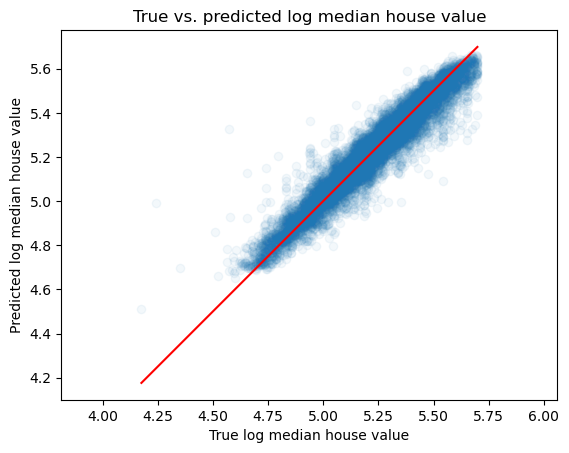

In [23]:
import matplotlib.pyplot as plt

plt.scatter(y_train_val, y_train_pred, alpha=0.05)
plt.plot(
    [min(y_train_val), max(y_train_val)],
    [min(y_train_val), max(y_train_val)],
    color='red',
)
plt.xlabel('True log median house value')
plt.ylabel('Predicted log median house value')
plt.title('True vs. predicted log median house value')
plt.axis('equal')
plt.show()

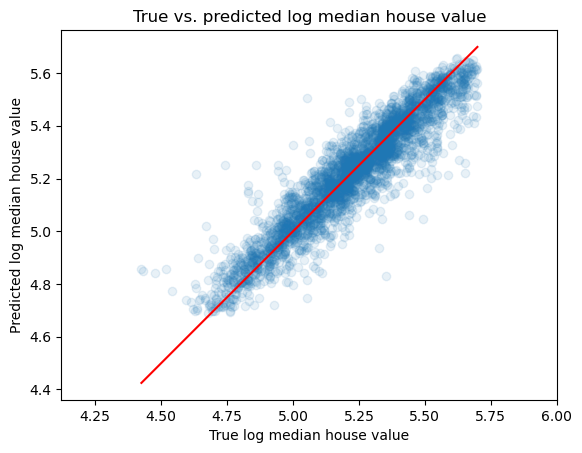

In [24]:
import matplotlib.pyplot as plt

plt.scatter(y_test_val, y_test_pred, alpha=0.1)
plt.plot(
    [min(y_test_val), max(y_test_val)],
    [min(y_test_val), max(y_test_val)],
    color='red',
)
plt.xlabel('True log median house value')
plt.ylabel('Predicted log median house value')
plt.title('True vs. predicted log median house value')
plt.axis('equal')
plt.show()

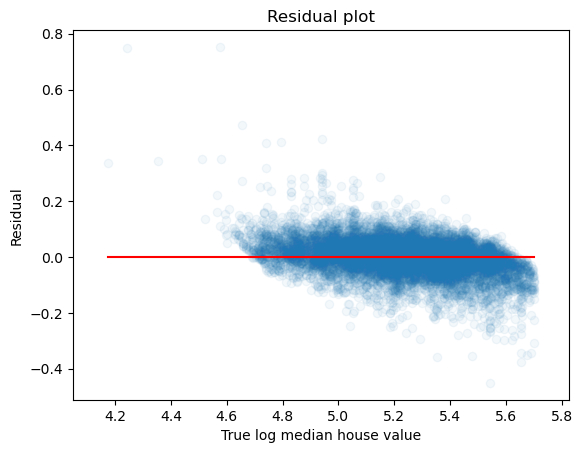

In [25]:
import matplotlib.pyplot as plt

plt.scatter(y_train_val, y_train_pred - y_train_val, alpha=0.05)
plt.plot([min(y_train_val), max(y_train_val)], [0, 0], color='red')
plt.xlabel('True log median house value')
plt.ylabel('Residual')
plt.title('Residual plot')
plt.axis('equal')
plt.show()

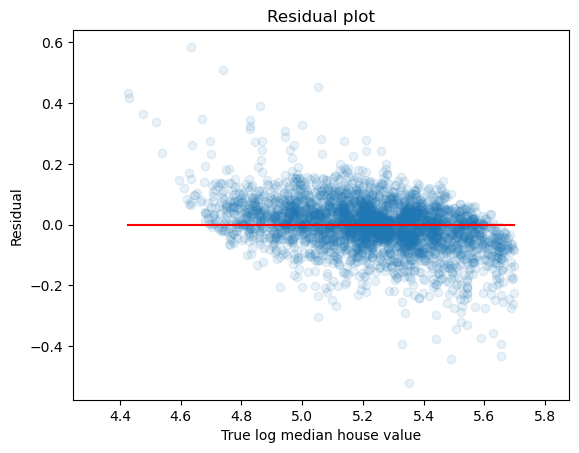

In [26]:
import matplotlib.pyplot as plt

plt.scatter(y_test_val, y_test_pred - y_test_val, alpha=0.1)
plt.plot([min(y_test_val), max(y_test_val)], [0, 0], color='red')
plt.xlabel('True log median house value')
plt.ylabel('Residual')
plt.title('Residual plot')
plt.axis('equal')
plt.show()

## Avaliação